In [1]:
%load_ext autotime

!nvidia-smi -L

import os

os.environ['CUDA_VISIBLE_DEVICES']='0'

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-3b49e2b8-87f0-c515-798b-3492ec05a183)
GPU 1: NVIDIA GeForce GTX 1080 Ti (UUID: GPU-07628ed7-6ef8-fd67-7d03-cb6a89f72de4)


In [2]:
import tensorflow as tf , numpy as np, matplotlib.pyplot as plt, glob
from tensorflow import keras
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
from PIL import Image
import albumentations as A

In [3]:
tf.config.get_visible_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
train_img_path = "./data/MoNuSeg 2018 Training Data/Tissue Images/"
train_mask_path = "./data/MoNuSeg 2018 Training Data/Masks/"

test_img_path = "./data/MoNuSegTestData/"
test_mask_path = "./data/MoNuSegTestData/Masks/"

train_img_files = sorted(glob.glob(train_img_path+"*.tif"))
train_mask_files = sorted(glob.glob(train_mask_path+"*.png"))

test_img_files = sorted(glob.glob(test_img_path+"*.tif"))
test_mask_files = sorted(glob.glob(test_mask_path+"*.png"))

In [5]:
# Add (12, 12) pad so Images get (1024, 1024) in size

def img_load(files_path, mask=False):
  res = []
  for img in tqdm(files_path, total=len(files_path)):
    im = Image.open(img)
    im = np.array(im)
    if mask:
      im_padded = np.pad(im, ((12, 12), (12, 12)), constant_values=0)
    else:
      im_padded = np.pad(im, ((12, 12), (12, 12), (0, 0)), constant_values=0)
    res.append(im_padded)
    
  return np.array(res)

In [6]:
train_images = img_load(train_img_files)
train_masks = img_load(train_mask_files, mask=True)
train_masks = np.expand_dims(train_masks, -1)

test_images = img_load(test_img_files)
test_masks = img_load(test_mask_files, mask=True)
test_masks = np.expand_dims(test_masks, -1)

print(train_images.shape, train_masks.shape)
print(test_images.shape, test_masks.shape)

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

(37, 1024, 1024, 3) (37, 1024, 1024, 1)
(14, 1024, 1024, 3) (14, 1024, 1024, 1)


In [7]:
X_train = train_images[:30]
Y_train = train_masks[:30]
X_valid = train_images[30:]
Y_valid = train_masks[30:] 
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)

X_train.max(), X_train.min() # so it's just need a rescale

(30, 1024, 1024, 3) (30, 1024, 1024, 1)
(7, 1024, 1024, 3) (7, 1024, 1024, 1)


(255, 0)

In [8]:
def no_overlap_patch(dataset, patch_size=256):
  res = []
  for item in dataset:
    ishape  = item.shape[0]
    for i in range(ishape//patch_size):
      c_p = i*patch_size
      n_p = (i+1)*patch_size
      patch = item[c_p:n_p, c_p:n_p, :]
      res.append(patch)
  
  return np.array(res)

In [9]:
X_train_patched = no_overlap_patch(X_train)
Y_train_patched = no_overlap_patch(Y_train) / 255.
X_valid_patched = no_overlap_patch(X_valid)
Y_valid_patched = no_overlap_patch(Y_valid) / 255.
print(X_train_patched.shape, Y_train_patched.shape)
print(X_valid_patched.shape, Y_valid_patched.shape)

(120, 256, 256, 3) (120, 256, 256, 1)
(28, 256, 256, 3) (28, 256, 256, 1)


(120, 256, 256, 3)


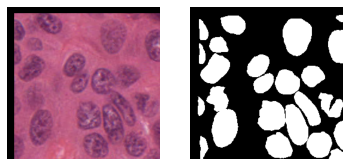

In [10]:
print(np.array(X_train_patched).shape)
im_p = Image.fromarray(X_train_patched[0])
# im_lp = Image.fromarray((Y_train_patched[0]*255).astype(np.uint8))
plt.subplot(1, 2, 1)
plt.imshow(im_p);
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow((Y_train_patched[0]*255).astype(np.uint8), cmap='gray');
plt.axis('off');

# data augmentation

In [11]:
transform = A.Compose([
  A.RandomBrightness(0.1),
  A.HorizontalFlip(p=0.5),
  A.RandomBrightnessContrast(0.1),
])

/home/kingeng/.venvs/tf2.9/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [12]:
X_train_pt, Y_train_pt, X_valid_pt, Y_valid_pt = [], [], [], [] 
for i in range(10):
  X_train_transformed = transform(image=X_train_patched, mask=Y_train_patched)
  X_valid_transformed = transform(image=X_valid_patched, mask=Y_valid_patched)
  
  X_train_pt.extend(X_train_transformed['image'])
  Y_train_pt.extend(X_train_transformed['mask'])
  X_valid_pt.extend(X_valid_transformed['image'])
  Y_valid_pt.extend(X_valid_transformed['mask'])

print(np.array(X_train_pt).shape, np.array(Y_train_pt).shape)

(1200, 256, 256, 3) (1200, 256, 256, 1)


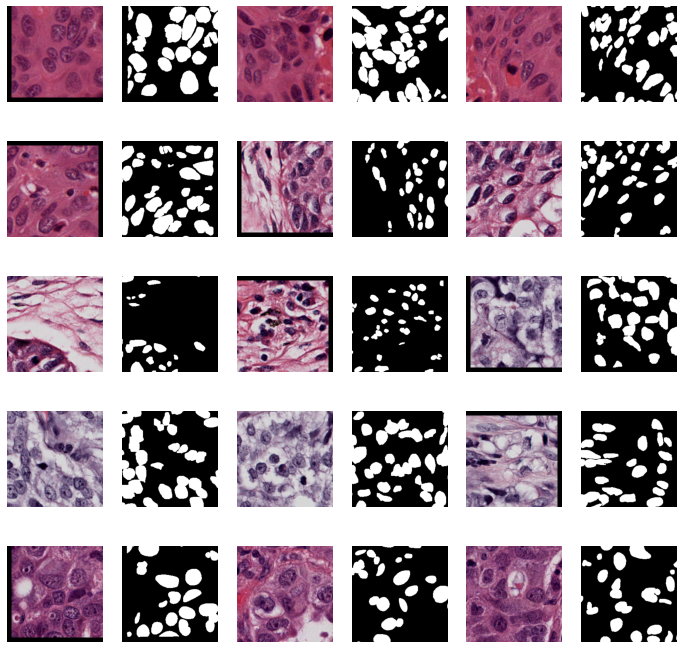

In [13]:
_, axs = plt.subplots(5, 6, figsize=(12, 12))
axs = axs.flatten()
comb = [None]*30
comb[::2] = X_train_pt[:15]
comb[1::2] = Y_train_pt[:15]

for img, ax in zip(comb, axs):
    ax.axis('off');
    if np.array(img).shape[-1] == 3:
        ax.imshow(np.array(img))
    ax.imshow(np.array(img),  cmap='gray')
    
plt.show()

In [14]:
  X_train_pt = np.array(X_train_pt)
  Y_train_pt = np.array(Y_train_pt)
  X_valid_pt = np.array(X_valid_pt)
  Y_valid_pt = np.array(Y_valid_pt)
  
  print(X_train_pt.shape, Y_train_pt.shape)

(1200, 256, 256, 3) (1200, 256, 256, 1)


In [15]:
keras.backend.clear_session()
filters = 32

inputs = keras.layers.Input(X_train_patched[0].shape)
x = keras.layers.Rescaling(1./255)(inputs)
x = keras.layers.Conv2D(filters*2, 3, strides=2, activation='relu', 
                        padding='same', kernel_regularizer='l2')(x)
x = keras.layers.Conv2D(filters*2, 3, activation='relu',
                        padding='same', kernel_regularizer='l2')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters*4, 3, strides=2, activation='relu',
                        padding='same', kernel_regularizer='l2')(x)
x = keras.layers.Conv2D(filters*4, 3, activation='relu',
                        padding='same', kernel_regularizer='l2')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters*8, 3, strides=2, activation='relu',
                        padding='same', kernel_regularizer='l2')(x)
x = keras.layers.Conv2D(filters*8, 3, activation='relu',
                        padding='same', kernel_regularizer='l2')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2DTranspose(filters*8, 3, activation='relu', padding='same')(x)
x = keras.layers.Conv2DTranspose(filters*8, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(filters*4, 3, activation='relu', padding='same')(x)
x = keras.layers.Conv2DTranspose(filters*4, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(filters*2, 3, activation='relu', padding='same')(x)
x = keras.layers.Conv2DTranspose(filters*2, 3, strides=2, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)

output = keras.layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                             

In [16]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_pt, Y_train_pt)).batch(16).shuffle(32).prefetch(32)
val_ds = tf.data.Dataset.from_tensor_slices((X_valid_pt, Y_valid_pt)).batch(16).shuffle(32).prefetch(32)

In [17]:
def iou(y_true, y_pred, smooth=1.):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    res = (intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) - intersection + smooth)
    
    return res

In [18]:
model.compile(
  optimizer = 'rmsprop',
  loss='binary_crossentropy',
  metrics = [iou]
)

In [19]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    "./checkpoints/MoNuSeg2018-pt.h5",
    save_best_only=True
  )
]

In [20]:
h = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
75/75 [==============================] - 12s 88ms/step - loss: 1.8545 - iou: 0.2514 - val_loss: 0.7478 - val_iou: 0.1885
Epoch 2/30
75/75 [==============================] - 6s 76ms/step - loss: 0.4123 - iou: 0.3523 - val_loss: 0.7150 - val_iou: 0.1565
Epoch 3/30
75/75 [==============================] - 6s 75ms/step - loss: 0.3559 - iou: 0.3855 - val_loss: 0.6462 - val_iou: 0.2636
Epoch 4/30
75/75 [==============================] - 6s 76ms/step - loss: 0.3329 - iou: 0.4074 - val_loss: 0.6331 - val_iou: 0.1999
Epoch 5/30
75/75 [==============================] - 5s 73ms/step - loss: 0.3249 - iou: 0.4156 - val_loss: 0.6707 - val_iou: 0.3142
Epoch 6/30
75/75 [==============================] - 6s 73ms/step - loss: 0.3076 - iou: 0.4360 - val_loss: 0.6438 - val_iou: 0.2804
Epoch 7/30
75/75 [==============================] - 6s 77ms/step - loss: 0.2938 - iou: 0.4504 - val_loss: 0.5705 - val_iou: 0.2462
Epoch 8/30
75/75 [==============================] - 6s 74ms/step - loss: 0.2839 - 

1/1 [==============================] - 0s 373ms/step


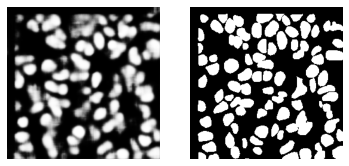

In [21]:
model = keras.models.load_model("./checkpoints/MoNuSeg2018-pt.h5", custom_objects={'iou':iou})

pred = model.predict(np.expand_dims(X_valid_patched[0], 0))

plt.subplot(1, 2, 1)
plt.imshow((pred[0]*255), cmap='gray');
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow((Y_valid_patched[0]*255), cmap='gray');
plt.axis('off');

1/1 [==============================] - 0s 163ms/step


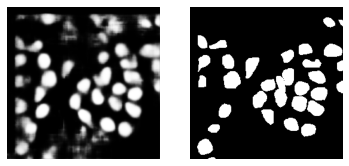

In [22]:
test_images_patched = no_overlap_patch(test_images) 
test_masks_patched = no_overlap_patch(test_masks)

model = keras.models.load_model("./checkpoints/MoNuSeg2018-pt.h5", custom_objects={'iou':iou})

pred = model.predict(np.expand_dims(test_images_patched[0], 0))

plt.subplot(1, 2, 1)
plt.imshow((pred[0]*255), cmap='gray');
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow((test_masks_patched[0]), cmap='gray');
plt.axis('off');

# 

### The next step is to apply these preprocessing techniques to pretrained models such as U-net 
__Try it yourself__